
<h1 style="border: 2px solid black; padding: 15px; border-radius: 12px;" align='center'>Cours IA et Applications</h1>    

<h2 align='center'> Deep Learning : Hugging Face </h2>

<h3 align='center'> Jordy Palafox </h3>
<h3 align='center'> Ing2 GSI/MI - 2023/2024 </h3>
      
      
<div style="display:flex"> 
    <img src="cytech.png", style="width:250px;height:50"> 
    <img src="cy.jpg", style="width:300px;height:100px"> 
</div> 

Dans ce notebook, on va suivre le tuto de classification proposé par HuggingFace ici : https://huggingface.co/docs/transformers/tasks/image_classification

Hugging Face c'est quoi ? 
Une startup française de Deep Learning qui propose des modèles open-source principalement en NLP.
Ils proposent essentiellement des modèles appelés Transformers qui sont des réseaux de neurones utilisant le mécanisme d'attention avec une architecture type encoder-decoder, ce mécanisme est présenté pour la première fois en 2017 dans l'article **All you need is attention** https://arxiv.org/abs/1706.03762 .
On verra quelques modèles au prochain chapitre mais surtout vous les découvrirez l'année prochaine en option IA !

# Chargement des données 

On va charger en premier lieu un petit data set (5Go quand même...)  de Food-101 de la librairie HuggingFace Dataset.
On pourra vérifier que tout marche sur un petit jeu de données avant de passer à un plus gros !

In [1]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

/home/jordy/anaconda3/envs/flowtorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset food101 (/home/jordy/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


In [3]:
# On découpe le jeu de données en jeu d'entrainement et jeu de test
food = food.train_test_split(test_size=0.2)

In [4]:
# Regardons un exemple
food['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=288x512>,
 'label': 79}

On voit que toutes les données sont composées d'une image PIL d'un aliment et d'une étiquette (class).

Pour faciliter les choses pour l'entrainement, on va créer un dictionnaire qui fait le lien entre une étiquette et un entier.

In [5]:
labels = food['train'].features['label'].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [6]:
id2label[str(85)]

'samosa'

# Préprocessing 

L'étape suivante est de charger un préparateur ViT d'images pour transformer les images en tensor.

In [7]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Pour éviter le surapprentissage et rendre le modèle robuste, on va ajouter de la data augmentation sur le jeu d'entraînement. 
Ici on utilise les couches de préprocessing de Keras pour définir les transformations du training set (dont la data augmentation) et les 
transformations sur l'ensemble de validation (seulement crop, resize et normalisation).

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

size = (image_processor.size['height'], image_processor.size['width'])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = 'train_data_augmentation'
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

2023-02-26 16:41:27.282388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 16:41:27.308870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 16:41:27.309036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 16:41:27.309637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Maintenant on créons des fonctions pour appliquer les transformations appropriées à des batch d'images, au lieu d'une image à chaque fois .

In [9]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

ON va utiliser *set_transform* pour appliquer les transformations

In [10]:
food["train"].set_transform(preprocess_train)
food["test"].set_transform(preprocess_val)

Pour terminer le préprocessing, créons un batch d'exembles avec DefauiltDataCollector. Qui contrairement aux autres data collectors n'appliquent aucune transformations additionnelles comme du padding.

In [11]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

# Evaluation

On introduit quelques outils pour évaluer les performations du modèle. Ici la librairie Evaluate le permet par exemple.

In [14]:
import evaluate

accuracy = evaluate.load("accuracy")

On créée ensuite une fonction qui va prendre en entrée les prédictions et labels pour calculer l'accuracy :

In [15]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

On peut passer à l'entraînement !

# Entrainement

Pour fine-tuner un modèle en TensorFlow, il faut suivre les étapes suivantes : 
1. Définir les hyperparamètres, créer un optimiseur et un "calendrier" du taux d'apprentissage,
2. Instancier un modèle pré-entrainé,
3. Convertir le dataset de HuggingFace en un format compatible avec TF (tf.data.Dataset),
4. Compiler le modèle, 
5. AJouter des callbacks et utiliser la méthode fit() pour lancer l'entraînement
6. Bonus : Uploader le modèle sur le hub HuggingFace pour partager à la communauté.

In [16]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
num_train_steps = len(food["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

On charge ensuite ViT avec TFAutoModelForImageClassification :

In [17]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint, 
    id2label = id2label,
    label2id = label2id,

)

2023-02-26 16:51:53.401548: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-02-26 16:51:55.016174: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-26 16:51:55.096043: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identic

On convertit le datasert avec tf.data.Datasets :

In [18]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = food["train"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = food["test"].to_tf_dataset(
    columns=["pixel_values"], label_cols=["label"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

On configure le modèle : 

In [19]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

Pour calculer l'accuracy à partir des prédictions on utilise des callbacks (on va pas faire celui pour push le modèle le HuggingFace Hub ...) :

In [23]:
from transformers.keras_callbacks import KerasMetricCallback
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)

callbacks = [metric_callback]


On est prêt pour entrainer le modèle avec **fit()** !!!!!!!

In [24]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/5
250/250 [==============================] - 129s 475ms/step - loss: 2.7907 - val_loss: 1.6157 - accuracy: 0.8290
Epoch 2/5
250/250 [==============================] - 114s 457ms/step - loss: 1.2386 - val_loss: 0.8379 - accuracy: 0.8990
Epoch 3/5
250/250 [==============================] - 116s 464ms/step - loss: 0.7241 - val_loss: 0.5320 - accuracy: 0.9110
Epoch 4/5
250/250 [==============================] - 117s 468ms/step - loss: 0.5088 - val_loss: 0.4257 - accuracy: 0.8960
Epoch 5/5
250/250 [==============================] - 115s 459ms/step - loss: 0.3841 - val_loss: 0.3646 - accuracy: 0.9050


C'est fait ! Dommage par contre, on fait un peu moins bien que sur le tuto en score mais on va 2 fois plus vite minimum !

Epoch 5/5
250/250 [==============================] - 238s 949ms/step - loss: 0.1232 - val_loss: 0.3259 - accuracy: 0.9890

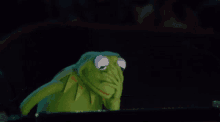

# On peut faire de l'inférence maintenant ! (de la prédiction !)

In [25]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

Found cached dataset food101 (/home/jordy/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


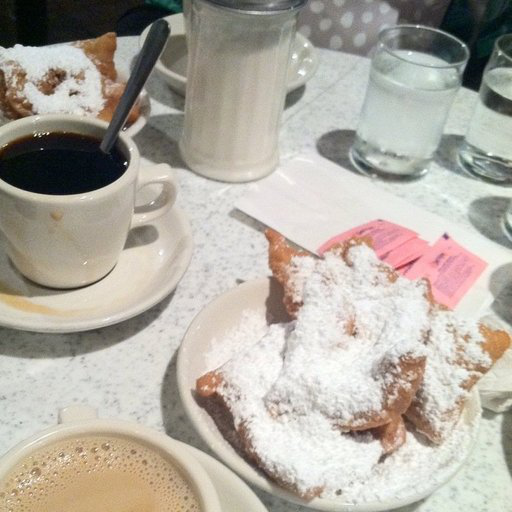

Pour le faire on va instantier une pipeline() pour classification d'images avec notre modèle et "passer l'image dedans"

Il faut être connecter à HuggingFace pour que ça fonctionne donc on va passer notre tour, mais on a vu **l'essentiel**.


Pour aller plus loin, faisons un tour ici : 
https://huggingface.co/

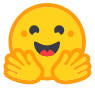